In [77]:

# import the necessary libraries: 

import kagglehub
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# EDA

In [78]:
#------------ get the data -------------

# Download latest version
path = kagglehub.dataset_download("mrsimple07/energy-consumption-prediction")

print("Path to dataset files:", path)

#check the directory
print(os.listdir(path))

data = pd.read_csv(os.path.join(path, "Energy_consumption.csv"))

Path to dataset files: /Users/cholponzhakshylykova/.cache/kagglehub/datasets/mrsimple07/energy-consumption-prediction/versions/1
['Energy_consumption.csv']


In [79]:
data.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


In [80]:


data.head(10)


data.head(10)
'''Same dates are asigned as a holiday and non-holiday, therefore I will drop the col [Holiday] '''


data.drop(["Holiday"], axis = 1, inplace=True)
print(data.columns)


#convert the "Timestamp" column to datetime
#The to_datetime() function is used to convert argument to datetime.

data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data.describe()
data.info()
'''
DatetimeIndex: 1000 entries, 2022-01-01 00:00:00 to 2022-02-11 15:00:00
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        1000 non-null   float64
 1   Humidity           1000 non-null   float64
 2   SquareFootage      1000 non-null   float64
 3   Occupancy          1000 non-null   int64  
 4   HVACUsage          1000 non-null   object 
 5   LightingUsage      1000 non-null   object 
 6   RenewableEnergy    1000 non-null   float64
 7   DayOfWeek          1000 non-null   object 
 8   Holiday            1000 non-null   object 
 9   EnergyConsumption  1000 non-null   float64
dtypes: float64(5), int64(1), object(4)
'''

#set timestamp as index
data_date_indexed = data.set_index("Timestamp", inplace=False) #keep the indexed timestamp as a column

print(len(data.columns))
'''10 columns'''


#find the initial and the end date

print(f"Initial date: {data_date_indexed.index.min()}")
print(f"End date: {data_date_indexed.index.max()}")

#since the data is all synthetic it is okay to experiment with all the possible ways to analyze the data. 


Index(['Timestamp', 'Temperature', 'Humidity', 'SquareFootage', 'Occupancy',
       'HVACUsage', 'LightingUsage', 'RenewableEnergy', 'DayOfWeek',
       'EnergyConsumption'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Timestamp          1000 non-null   datetime64[ns]
 1   Temperature        1000 non-null   float64       
 2   Humidity           1000 non-null   float64       
 3   SquareFootage      1000 non-null   float64       
 4   Occupancy          1000 non-null   int64         
 5   HVACUsage          1000 non-null   object        
 6   LightingUsage      1000 non-null   object        
 7   RenewableEnergy    1000 non-null   float64       
 8   DayOfWeek          1000 non-null   object        
 9   EnergyConsumption  1000 non-null   float64       
dtypes: datetime64[ns](1), float64(5)

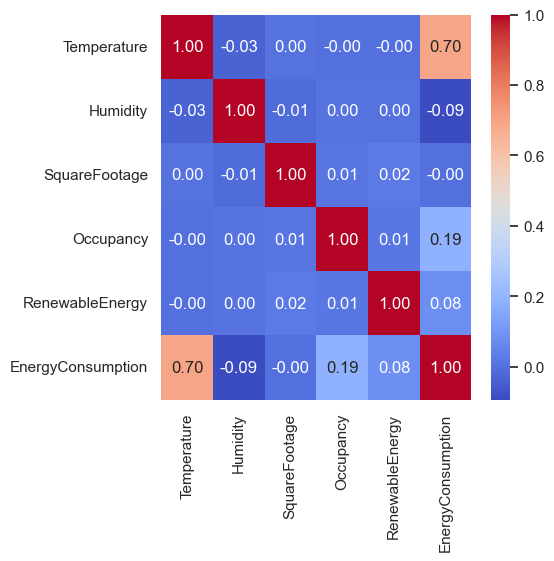

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Timestamp          1000 non-null   datetime64[ns]
 1   Temperature        1000 non-null   float64       
 2   Humidity           1000 non-null   float64       
 3   SquareFootage      1000 non-null   float64       
 4   Occupancy          1000 non-null   int64         
 5   HVACUsage          1000 non-null   object        
 6   LightingUsage      1000 non-null   object        
 7   RenewableEnergy    1000 non-null   float64       
 8   DayOfWeek          1000 non-null   object        
 9   EnergyConsumption  1000 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 78.3+ KB


<Figure size 640x480 with 0 Axes>

In [81]:


#correlation analysis
# %%
numeric_data = data.select_dtypes(include=["int64", "float64"]).columns
corr = data[numeric_data].corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot= True, cmap="coolwarm", fmt = ".2f", cbar = True, linewidths = 0)
plt.show()
plt.savefig("correlation_matrix.png", dpi = 300, bbox_inches = "tight")

# there is a strong correlation for of Temperature with Energyconsumption
# %%

data.info()

In [82]:

# Dealing with categorical Data
# ANOVA Test for the categorical variables. 
# NO need to normalize the energyconsumption when using ANOVA

import pandas as pd
from scipy import stats

X = data[["HVACUsage","LightingUsage", "DayOfWeek"]]
y = data["EnergyConsumption"]

#apply ANOVA
anova_result_hvac = stats.f_oneway(y[X["HVACUsage"] == "On"], y[X["HVACUsage"] == "Off"])

print("ANOVA result for HVACusage (On vs Off)")
print(f"F-statistics, {anova_result_hvac.statistic:.5f}")
print(f"F-statistics, {anova_result_hvac.pvalue:.5f}")


#apply ANOVA
anova_result_Lighting = stats.f_oneway(y[X["LightingUsage"] == "On"], y[X["LightingUsage"] == "Off"])

print("ANOVA result for LightingUsage (On vs Off)")
print(f"F-statistics, {anova_result_Lighting.statistic:.5f}")
print(f"F-statistics, {anova_result_Lighting.pvalue:.5f}")


#apply ANOVA on DayOfWeek

#apply ANOVA
anova_result_day = stats.f_oneway(y[X["DayOfWeek"] == "Monday"], y[X["DayOfWeek"] == "Tuesday"], y[X["DayOfWeek"] == "Wednesday"],
                                       y[X["DayOfWeek"] == "Thursday"], y[X["DayOfWeek"] == "Friday"], y[X["DayOfWeek"] == "Saturday"],
                                       y[X["DayOfWeek"] == "Sunday"])
                                      

print("ANOVA result for LightingUsage (On vs Off)")
print(f"F-statistics, {anova_result_day.statistic:.5f}")
print(f"F-statistics, {anova_result_day.pvalue:.5f}")


ANOVA result for HVACusage (On vs Off)
F-statistics, 89.21920
F-statistics, 0.00000
ANOVA result for LightingUsage (On vs Off)
F-statistics, 8.78716
F-statistics, 0.00311
ANOVA result for LightingUsage (On vs Off)
F-statistics, 0.31565
F-statistics, 0.92902


- Mean EnergyConsumption for HVACUsage ON is significantly different to those with HVACUsage Off
- Mean EnergyConsumption for Lighting ON is significantly different to those with Lighting Off
- Mean EnergyConsumption does not differ accross differend days of week

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Timestamp          1000 non-null   datetime64[ns]
 1   Temperature        1000 non-null   float64       
 2   Humidity           1000 non-null   float64       
 3   SquareFootage      1000 non-null   float64       
 4   Occupancy          1000 non-null   int64         
 5   HVACUsage          1000 non-null   object        
 6   LightingUsage      1000 non-null   object        
 7   RenewableEnergy    1000 non-null   float64       
 8   DayOfWeek          1000 non-null   object        
 9   EnergyConsumption  1000 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 78.3+ KB


### Outlier Detection 

##  Time series Visualizations

Text(0.5, 1.0, 'Energy Consumption over the whole dataset')

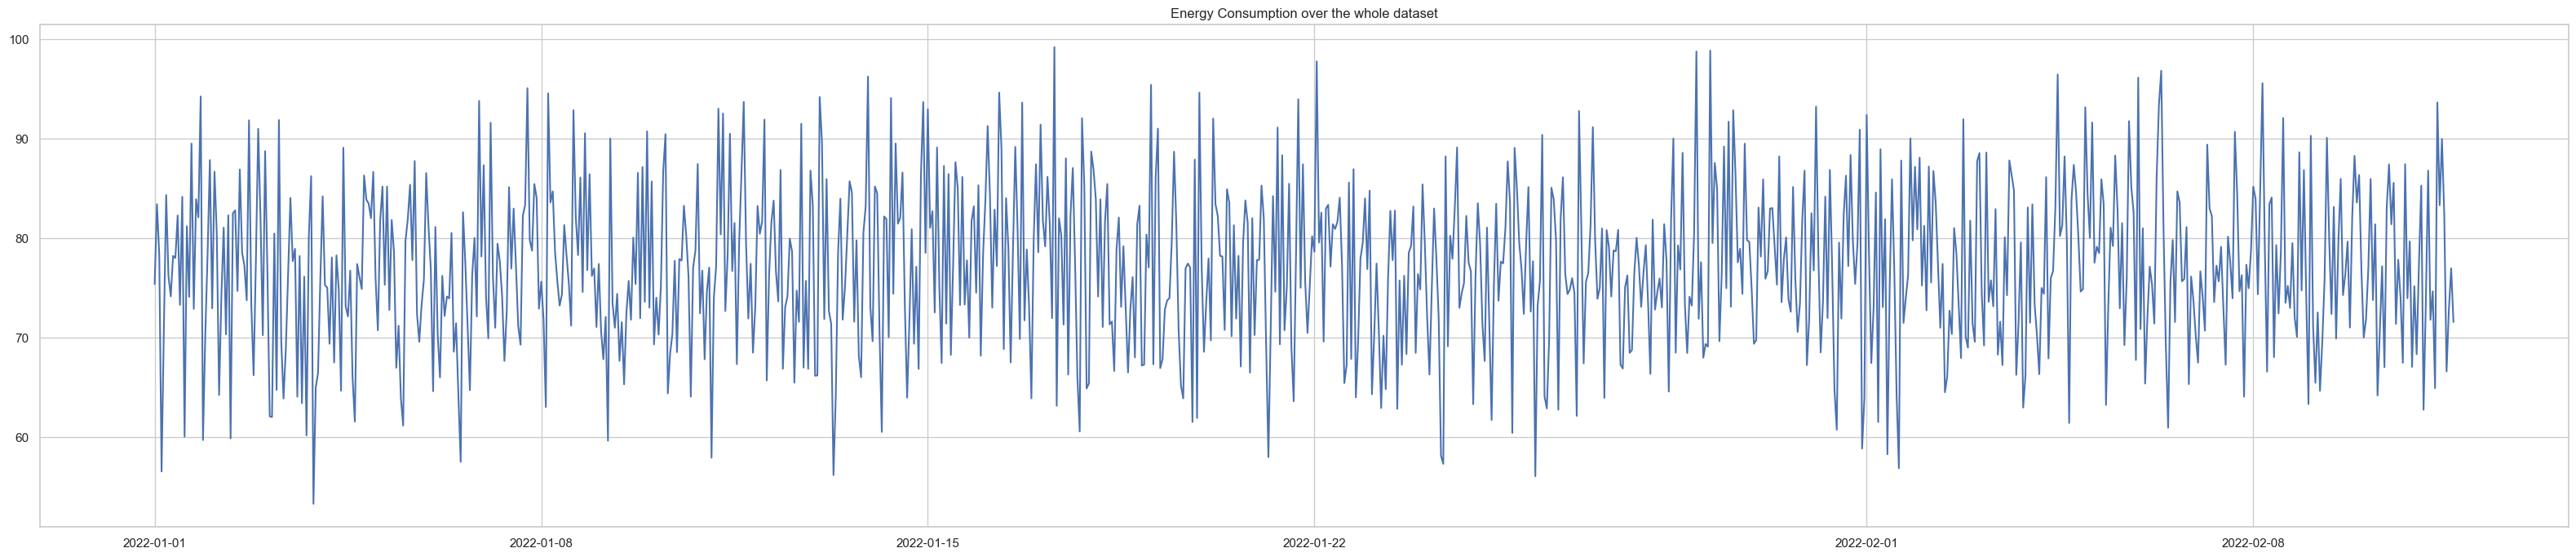

In [84]:
from datetime import datetime
import matplotlib.pyplot as plt
import datetime
import numpy as np

# for this use the data without indexation of the datetime: 

#data["Timestamp"] = pd.to_datetime(data["Timestamp"])

data = data.sort_values("Timestamp")

plt.figure(figsize = (40,8))

plt.plot(data["Timestamp"], data["EnergyConsumption"])
plt.title("Energy Consumption over the whole dataset")

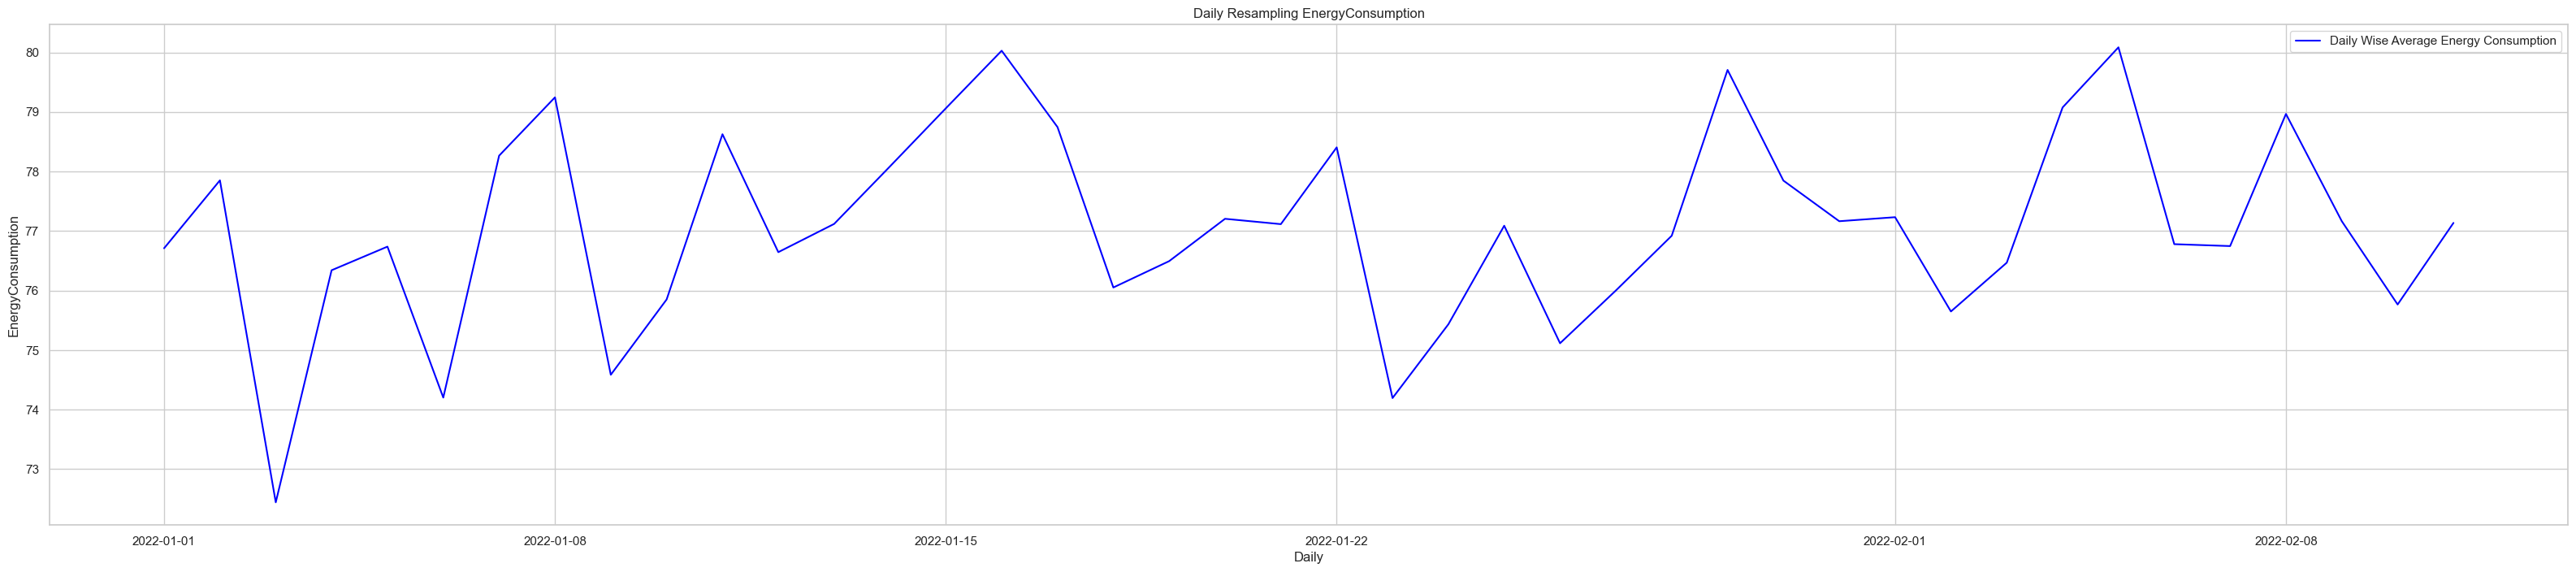

In [85]:
# Resampling per daily

#resample to daily frequency

df_resampled = data_date_indexed.resample("D").mean(numeric_only=True)
sns.set(style="whitegrid")

plt.figure(figsize=(40,8))
sns.lineplot(data = df_resampled, x = df_resampled.index, y = "EnergyConsumption", label = "Daily Wise Average Energy Consumption", color = "blue")

plt.xlabel("Daily")
plt.ylabel("EnergyConsumption")
plt.title("Daily Resampling EnergyConsumption")

plt.show()



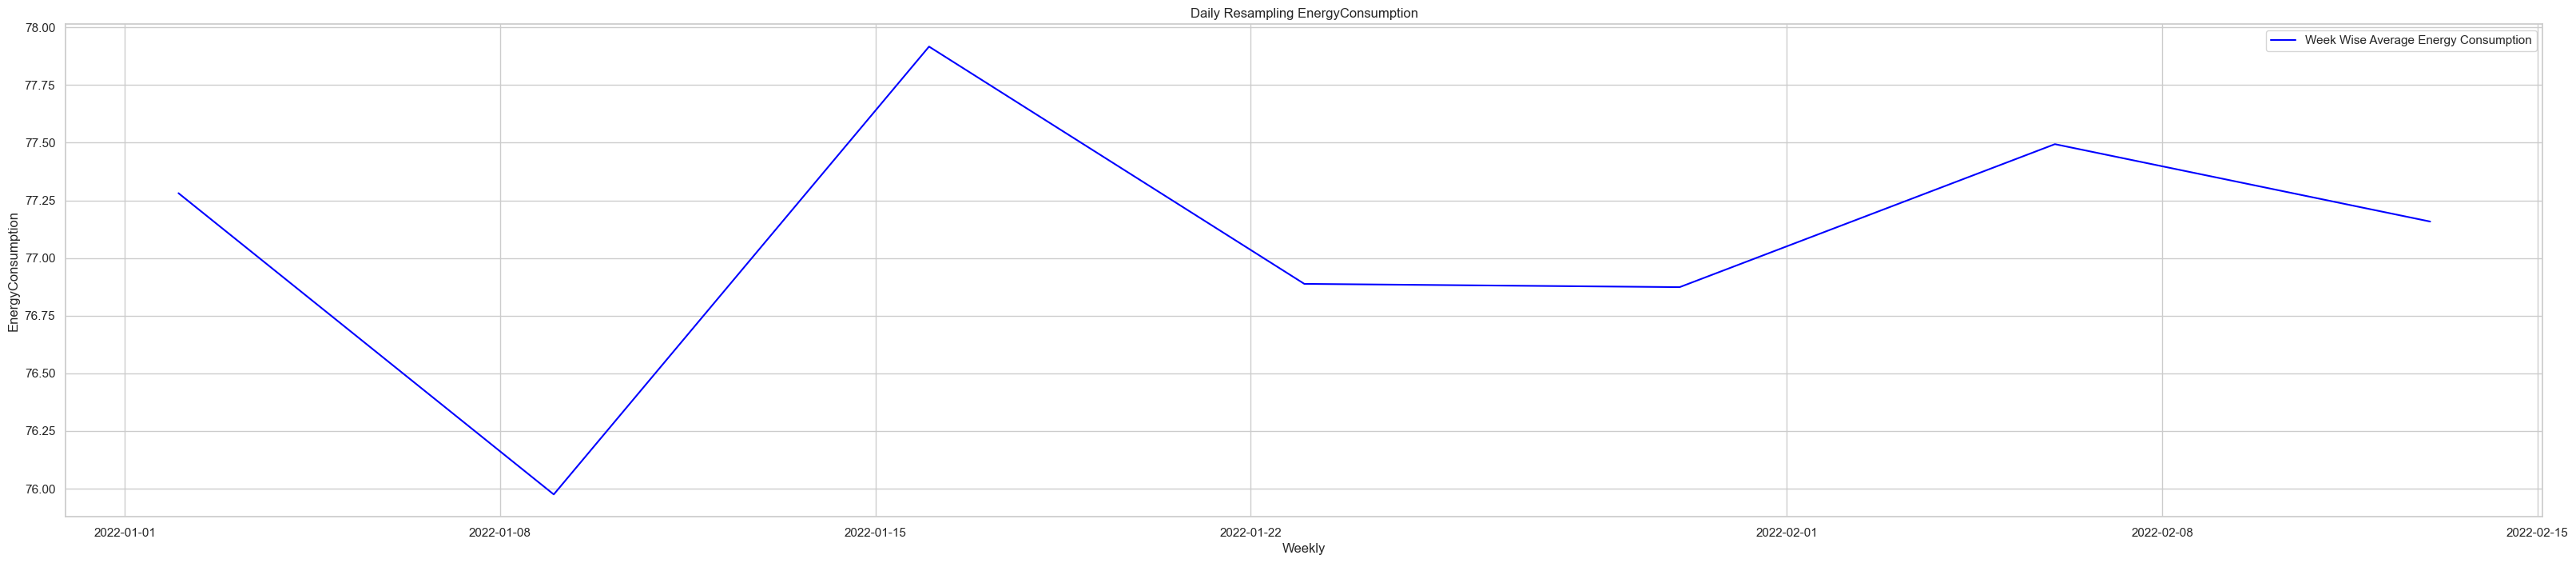

In [86]:
# Resampling per week

#resample to weekly frequency

df_resampled = data_date_indexed.resample("W").mean(numeric_only=True)
sns.set(style="whitegrid")

plt.figure(figsize=(40,8))
sns.lineplot(data = df_resampled, x = df_resampled.index, y = "EnergyConsumption", label = "Week Wise Average Energy Consumption", color = "blue")

plt.xlabel("Weekly")
plt.ylabel("EnergyConsumption")
plt.title("Daily Resampling EnergyConsumption")

plt.show()



<Figure size 1200x600 with 0 Axes>

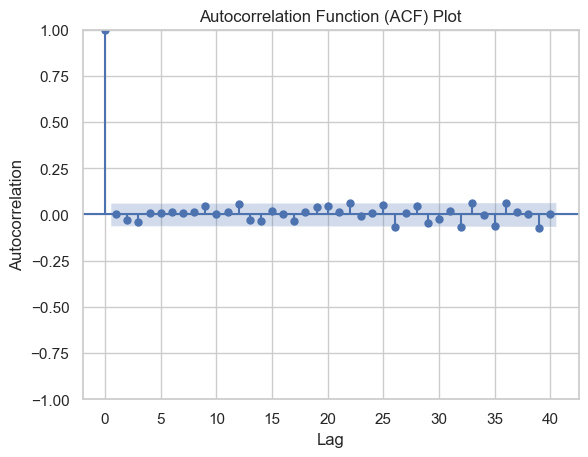

In [87]:
#Detecting seasonality using Auto correlation: 

# Plot the ACF
plt.figure(figsize=(12, 6))
plot_acf(data_date_indexed['EnergyConsumption'], lags=40) # You can adjust the number of lags as needed
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()




Detecting stationarity:

- use ADF test:
- The test is based on the;

    -   Null hypothesis that a unit root is present in the time series, indicating that the series is non-stationary.
    -   The alternative hypothesis is that the series is stationary after differencing (i.e., it has no unit root).
- The ADF test employs an augmented regression model that includes lagged differences of the series to determine the presence of a unit root.


In [88]:
from statsmodels.tsa.stattools import adfuller


result = adfuller(data_date_indexed['EnergyConsumption'])
print(result)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4]) 

(np.float64(-31.576934146718358), 0.0, 0, 999, {'1%': np.float64(-3.4369127451400474), '5%': np.float64(-2.864437475834273), '10%': np.float64(-2.568312754566378)}, np.float64(6868.541335798459))
ADF Statistic: -31.576934146718358
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4369127451400474), '5%': np.float64(-2.864437475834273), '10%': np.float64(-2.568312754566378)}


Summary for the stationarity: according to what I undestood, the data for the energy consumption is not stationary. "Based on the ADF Statistici.e > all Critical Values, So, we accept the null hypothesis and conclude that the data does not appear to be stationary according to the Augmented Dickey-Fuller test.
This suggests that differencing or other transformations may be needed to achieve stationarity before applying certain time series models."

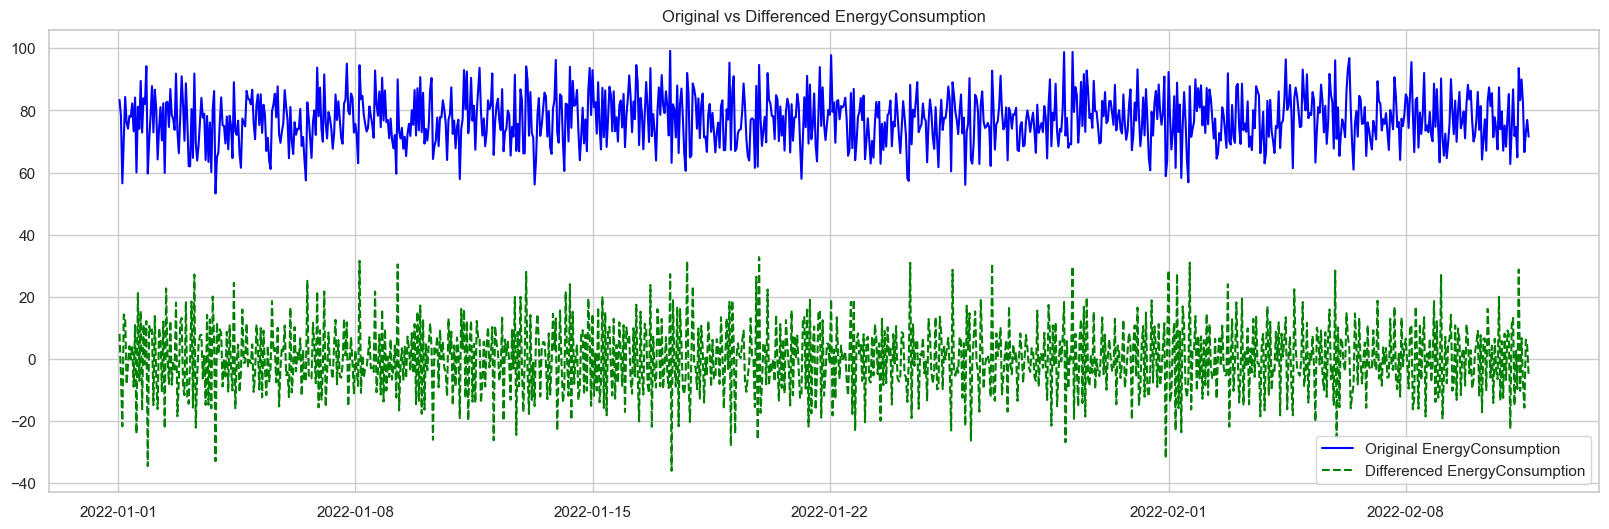

In [94]:
# Differencing: involves subtracting the previous observation from the current observation to remove trends or seasonality.

# Differencing: involves subtracting the previous observation from the current observation to remove trends or seasonality.

data_date_indexed['EnergyConsumption_diff'] = data_date_indexed['EnergyConsumption'].diff()

# Plotting
plt.figure(figsize=(20, 6))
plt.plot(data["Timestamp"], data['EnergyConsumption'], label='Original EnergyConsumption', color='blue')
plt.plot(data["Timestamp"], data['EnergyConsumption_diff'], label='Differenced EnergyConsumption', linestyle='--', color='green')
plt.legend()
plt.title('Original vs Differenced EnergyConsumption')
plt.show()

Differencing operation is commonly used to transform a time series into a new series that represents the changes between consecutive observations.

Summary for the plots: 

- Trend: the trends goes up for the energy usage
- Seasonality: there is no seasonality
- Stationarity: 


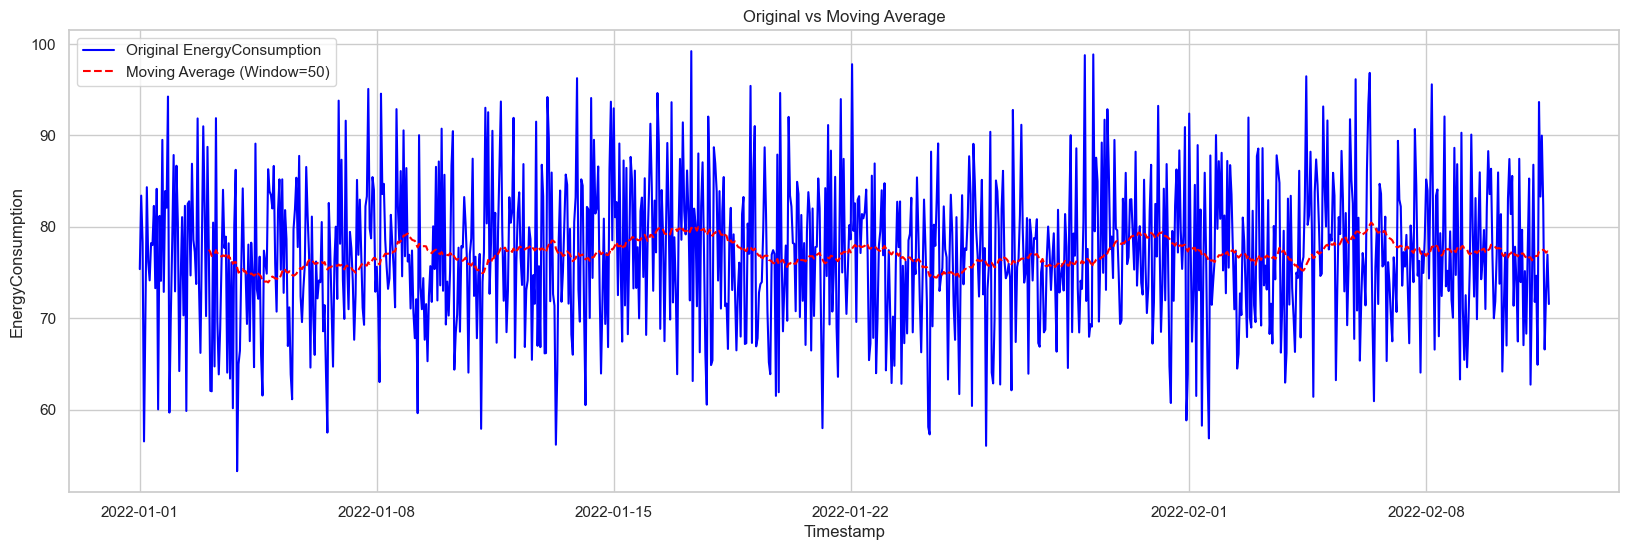

In [90]:
# Moving Average
window_size = 50
data['EnergyConsumption_smoothed'] = data['EnergyConsumption'].rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(20, 6))

plt.plot(data["Timestamp"], data['EnergyConsumption'], label='Original EnergyConsumption', color='blue')
plt.plot(data["Timestamp"], data['EnergyConsumption_smoothed'], label=f'Moving Average (Window={window_size})', linestyle='--', color='red')

plt.xlabel('Timestamp')
plt.ylabel('EnergyConsumption')
plt.title('Original vs Moving Average')
plt.legend()
plt.show()

In [95]:
#Printing the original and differenced data side by side we get;

# Create a DataFrame with 'high' and 'high_diff' columns side by side
df_combined = pd.concat([data['EnergyConsumption'], data['EnergyConsumption_diff']], axis=1)

# Display the combined DataFrame
print(df_combined.head())

   EnergyConsumption  EnergyConsumption_diff
1          83.401855                8.037482
2          78.270888               -5.130967
3          56.519850              -21.751037
4          70.811732               14.291882
5          84.321885               13.510153


In [97]:
# Remove rows with missing values
data.dropna(subset=['EnergyConsumption_diff'], inplace=True)
data['EnergyConsumption_diff'].head()

1     8.037482
2    -5.130967
3   -21.751037
4    14.291882
5    13.510153
Name: EnergyConsumption_diff, dtype: float64

In [99]:
from statsmodels.tsa.stattools import adfuller

# Assuming df is your DataFrame
result = adfuller(data['EnergyConsumption_diff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -12.803800024126387
p-value: 6.667008105694873e-24
Critical Values: {'1%': np.float64(-3.437054035425408), '5%': np.float64(-2.8644997864059363), '10%': np.float64(-2.5683459429326576)}


# ARMA

#follow along the tutorial https://builtin.com/data-science/time-series-model

In [100]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


In [101]:
plt.rcParams["figure.figsize"]  = [10,7.5]

In [ ]:
#Simulate ARMA(1,1)